In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, random, string
from collections import defaultdict

## Preprocessing and Visualize data

In [28]:
corpus = ['i love playing football',
          'i want to become a teacher',
          'i love ice cream',
          'i enjoy playing tennis',
          'do you play batminton with me']

def count_co_occurence(corpus, window_size):
  co_occurence, all_words = {}, []
  for sentence in corpus:
    sentence = sentence.split()
    for i, word in enumerate(sentence):
      start = max(0, i - window_size)
      end = min(len(sentence), i + window_size + 1)
      for j in range(start, end):
        if j != i:
          if (word, sentence[j]) not in co_occurence:
            co_occurence[(word, sentence[j])] = 1
          else:
            co_occurence[(word, sentence[j])] += 1
      if word not in all_words:
        all_words.append(word)
  return co_occurence, all_words

def create_dataframe(co_occurence, all_words):
  data = []
  for word in all_words:
    dict = {}
    for id in range(len(all_words)):
      if (word, all_words[id]) in co_occurence:
        dict[all_words[id]] = co_occurence[(word, all_words[id])]
      else:
        dict[all_words[id]] = 0
    data.append(dict)

  df = pd.DataFrame(data, index = all_words)
  return df

In [29]:
co_occurence, all_words = count_co_occurence(corpus, window_size = 2)
df = create_dataframe(co_occurence, all_words)
df

,i,love,playing,football,want,to,become,a,teacher,ice,cream,enjoy,tennis,do,you,play,batminton,with,me
i,0,2,2,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0
love,2,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
playing,2,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
football,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
want,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
to,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
become,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0
a,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
teacher,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
ice,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## GloVe model

In [30]:
co_occurence.items()

dict_items([(('i', 'love'), 2), (('i', 'playing'), 2), (('love', 'i'), 2), (('love', 'playing'), 1), (('love', 'football'), 1), (('playing', 'i'), 2), (('playing', 'love'), 1), (('playing', 'football'), 1), (('football', 'love'), 1), (('football', 'playing'), 1), (('i', 'want'), 1), (('i', 'to'), 1), (('want', 'i'), 1), (('want', 'to'), 1), (('want', 'become'), 1), (('to', 'i'), 1), (('to', 'want'), 1), (('to', 'become'), 1), (('to', 'a'), 1), (('become', 'want'), 1), (('become', 'to'), 1), (('become', 'a'), 1), (('become', 'teacher'), 1), (('a', 'to'), 1), (('a', 'become'), 1), (('a', 'teacher'), 1), (('teacher', 'become'), 1), (('teacher', 'a'), 1), (('i', 'ice'), 1), (('love', 'ice'), 1), (('love', 'cream'), 1), (('ice', 'i'), 1), (('ice', 'love'), 1), (('ice', 'cream'), 1), (('cream', 'love'), 1), (('cream', 'ice'), 1), (('i', 'enjoy'), 1), (('enjoy', 'i'), 1), (('enjoy', 'playing'), 1), (('enjoy', 'tennis'), 1), (('playing', 'enjoy'), 1), (('playing', 'tennis'), 1), (('tennis', 'e

In [31]:
class glove():
  def __init__(self, learning_rate, num_epochs, embedding_size):
    self.learning_rate = learning_rate
    self.num_epochs = num_epochs
    self.embedding_size = embedding_size

  def init_embedding(self):
    return {word: np.random.randn(self.embedding_size) for word in all_words}

  def run(self):
    embeddings = self.init_embedding()
    history = []
    for epoch in range(self.num_epochs):
      total_loss = 0
      for (word_i, word_j), count in co_occurence.items():
        similarity = np.dot(embeddings[word_i], embeddings[word_j])
        gradient = (similarity - np.log(count)) * embeddings[word_j]
        embeddings[word_i] -= self.learning_rate * gradient
      for (word_i, word_j), count in co_occurence.items():
        total_loss += 0.5 * (np.dot(embeddings[word_i], embeddings[word_j]) - np.log(count))**2
      if epoch % 50 == 0:
        print("After epoch {}, total loss is {}".format(epoch, total_loss))
      history.append(total_loss)
    return history, embeddings

In [32]:
model = glove(learning_rate = 0.01, num_epochs = 1000, embedding_size = 10)
history, embeddings = model.run()

After epoch 0, total loss is 127.26675414184696
After epoch 50, total loss is 0.07460777374389622
After epoch 100, total loss is 0.0018723218928916525
After epoch 150, total loss is 5.884860962983667e-05
After epoch 200, total loss is 1.962664966951413e-06
After epoch 250, total loss is 6.645602903045913e-08
After epoch 300, total loss is 2.258519498575394e-09
After epoch 350, total loss is 7.682031488622365e-11
After epoch 400, total loss is 2.6133458900097407e-12
After epoch 450, total loss is 8.890433063375893e-14
After epoch 500, total loss is 3.024433295369176e-15
After epoch 550, total loss is 1.028870520536963e-16
After epoch 600, total loss is 3.50005297541615e-18
After epoch 650, total loss is 1.1906583971158753e-19
After epoch 700, total loss is 4.0503656837271424e-21
After epoch 750, total loss is 1.3778696969589786e-22
After epoch 800, total loss is 4.688191898827469e-24
After epoch 850, total loss is 1.600870959503721e-25
After epoch 900, total loss is 5.334485611009496e-2

## Visualize loss

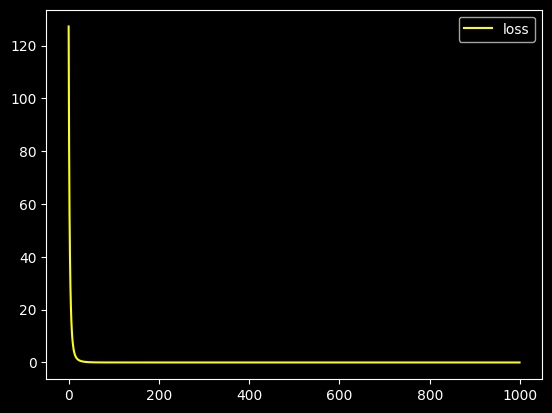

In [33]:
plt.style.use('dark_background')
plt.plot(history, c = 'yellow', label = 'loss')
plt.legend()
plt.show()

In [46]:
for word_1 in all_words:
  similarity = [np.dot(embeddings[word_1], embeddings[word_2]) for word_2 in all_words]
  similarity_index = np.argsort(similarity)
  similar_words = [all_words[index] for index in similarity_index[len(all_words) - 2 : len(all_words)] if all_words[index] != word_1]
  print('{} | {}'.format(word_1, similar_words))

i | ['me']
love | ['a']
playing | ['a']
football | ['tennis']
want | ['ice']
to | ['playing']
become | ['tennis']
a | ['love']
teacher | ['enjoy']
ice | ['want']
cream | ['football']
enjoy | ['love']
tennis | ['football']
do | ['with']
you | ['want']
play | ['playing']
batminton | ['love']
with | ['do']
me | ['enjoy']
